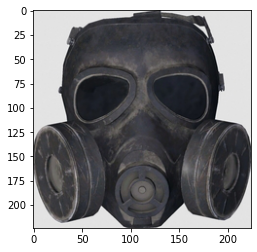

In [129]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib
from matplotlib import pyplot as plt

#open image convert to tensor
mask_img = Image.open("gasmask.jpg")
mask_tensor = transforms.ToTensor()(mask_img)[None,:,:,:]

# plot image convert HWC to CHW for pytorch
plt.imshow(mask_tensor[0].numpy().transpose(1,2,0))


In [131]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();


In [132]:
#runs normalized mask_tensor through resnet50
pred = model(norm(mask_tensor))


In [133]:
#reads prediction
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

print(imagenet_classes[pred.max(dim=1)[1].item()])


gasmask


In [148]:

#reads loss between model prediction and true gasmask tensor
print(nn.CrossEntropyLoss()(model(norm(mask_tensor)),torch.LongTensor([570])).item())


0.015931107103824615


In [152]:
import torch.optim as optim
import numpy as np
#set bounds for perturbation
epsilon = 2./255
#make empty tensor the size of mask_tensor
delta = torch.zeros_like(mask_tensor, requires_grad=True)
#optimization method is stochastic gradient descent with respect to the new tensor (learning rate is 0.1)
opt = optim.SGD([delta], lr=0.1)

for t in range(30):

    #a prediction is made on normalized mask_tensor + delta
    pred = model(norm(mask_tensor + delta))
    #loss between model prediction and gasmask class tensor is calculated
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([570]))
    print(loss)
    #clears old gradients from the last step
    opt.zero_grad()
    #computes the gradient of the loss with respect to delta
    loss.backward()
    #optimizer steps 0.1 in the direction of the gradient
    opt.step()
    #retains delta between a minimum and maximum perturbation if necessary
    delta.data.clamp_(-epsilon, epsilon)
#converts tensor to probability distribution  

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

#print(torch.max(softmax(pred.detach())))
print("True class probability:", nn.Softmax(dim=1)(pred)[0,570].item())


tensor(-0.0159, grad_fn=<NegBackward>)
tensor(-0.0296, grad_fn=<NegBackward>)
tensor(-0.0788, grad_fn=<NegBackward>)
tensor(-0.4914, grad_fn=<NegBackward>)
tensor(-5.0168, grad_fn=<NegBackward>)
tensor(-11.1517, grad_fn=<NegBackward>)
tensor(-15.9191, grad_fn=<NegBackward>)
tensor(-19.0343, grad_fn=<NegBackward>)
tensor(-18.2039, grad_fn=<NegBackward>)
tensor(-18.0214, grad_fn=<NegBackward>)
tensor(-16.8144, grad_fn=<NegBackward>)
tensor(-22.0278, grad_fn=<NegBackward>)
tensor(-23.9941, grad_fn=<NegBackward>)
tensor(-19.8970, grad_fn=<NegBackward>)
tensor(-17.3310, grad_fn=<NegBackward>)
tensor(-23.2669, grad_fn=<NegBackward>)
tensor(-23.5982, grad_fn=<NegBackward>)
tensor(-25.8596, grad_fn=<NegBackward>)
tensor(-20.2193, grad_fn=<NegBackward>)
tensor(-20.0849, grad_fn=<NegBackward>)
tensor(-22.5254, grad_fn=<NegBackward>)
tensor(-26.4365, grad_fn=<NegBackward>)
tensor(-23.2888, grad_fn=<NegBackward>)
tensor(-23.8178, grad_fn=<NegBackward>)
tensor(-22.3182, grad_fn=<NegBackward>)
tenso

TypeError: max() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * ()
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out


In [145]:

max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())


Predicted class:  cuirass
Predicted probability: 0.5594501495361328


In [ ]:
# plot image convert HWC to CHW for pytorch
plt.imshow((mask_tensor + delta)[0].detach().numpy().transpose(1,2,0))





In [ ]:
# plot image convert HWC to CHW for pytorch
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))